In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [3]:
# Directory
dataset_dir = "C:/Users/ellor/Documents/Nuclei Segmentation/dataset"
data_dir= "C:/Users/ellor/Documents/Nuclei Segmentation/data"
bounding_box_dir = "C:/Users/ellor/Documents/Nuclei Segmentation/bbox"

## Understanding the Dataset

In [4]:
# Function to count files
def count_files(directory, file_suffix):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(file_suffix):
            count += 1
    return count

# Counting "_original.png" and "_mask.png" files
original_count = count_files(dataset_dir, "_original.tif")
mask_count = count_files(dataset_dir, "_mask.png")

print(f"Number of image files: {original_count}")
print(f"Number of mask files: {mask_count}")

Number of image files: 141
Number of mask files: 141


## Pre-processing the Data

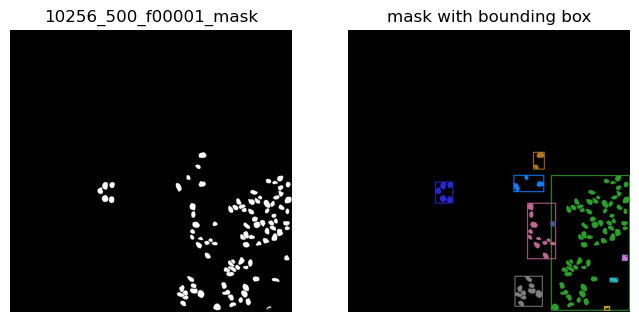

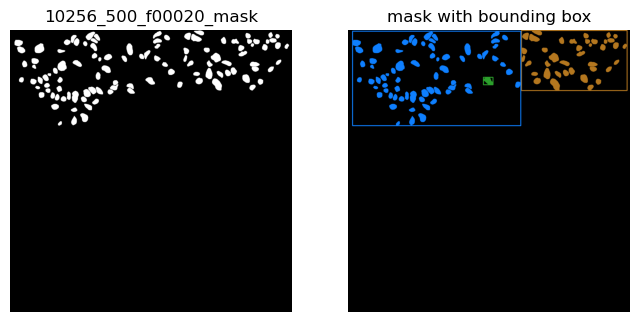

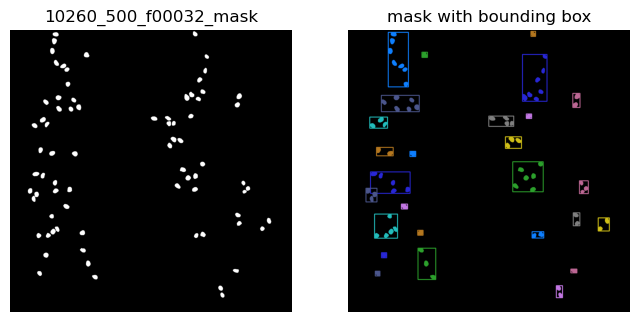

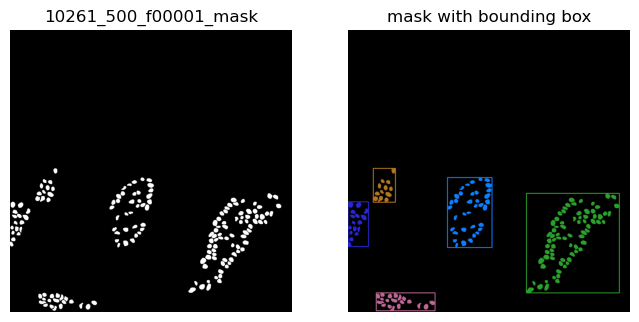

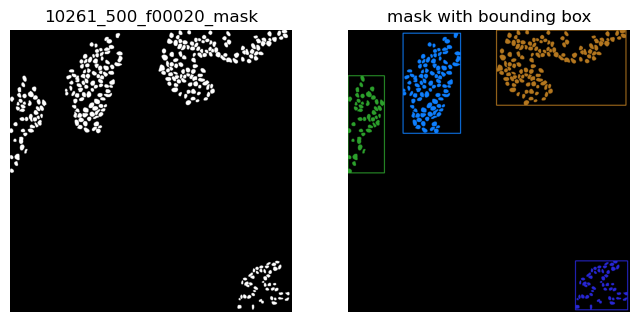

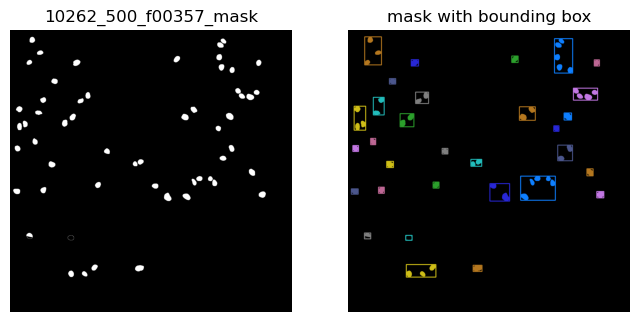

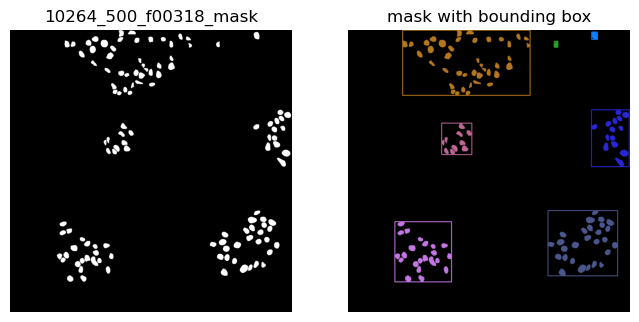

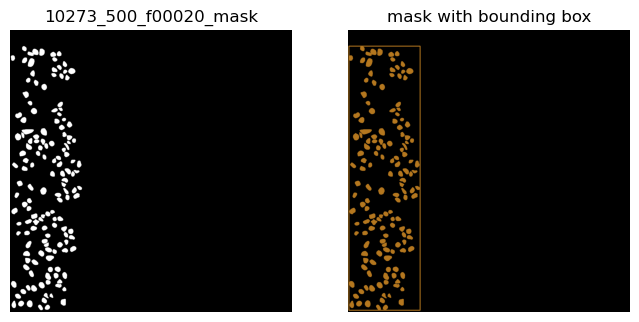

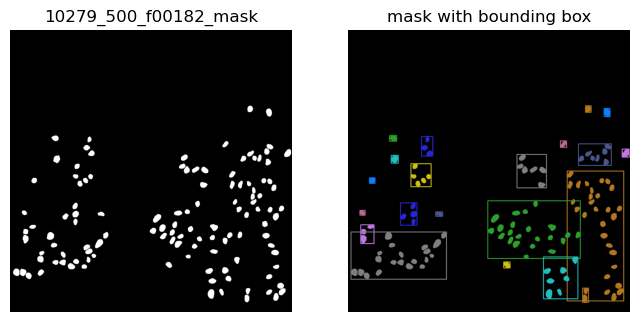

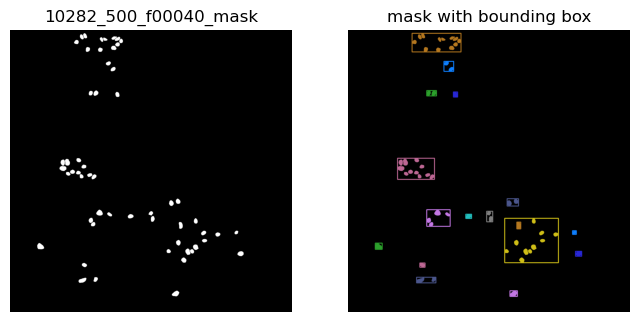

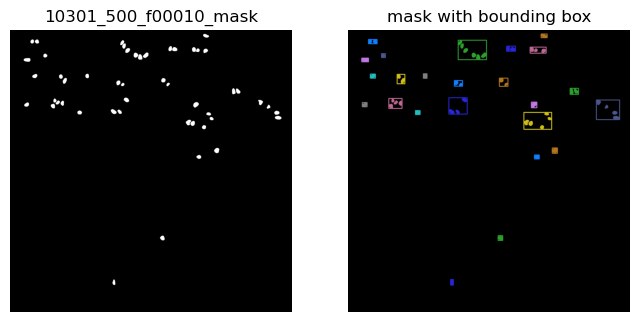

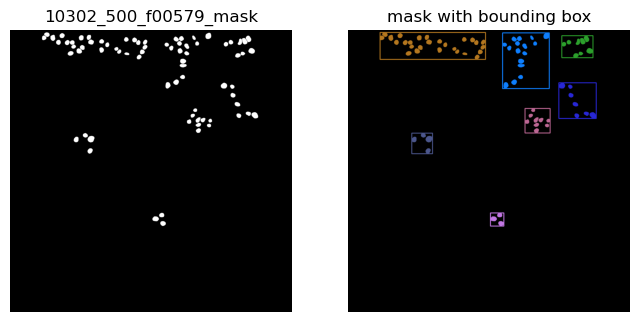

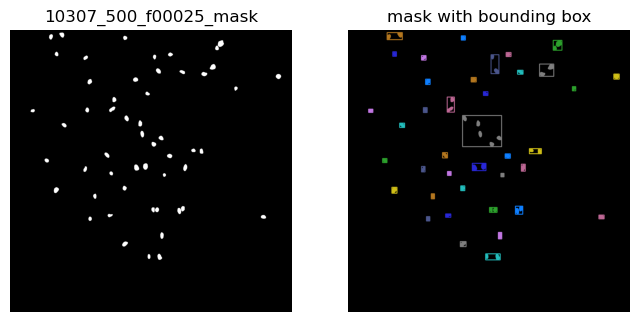

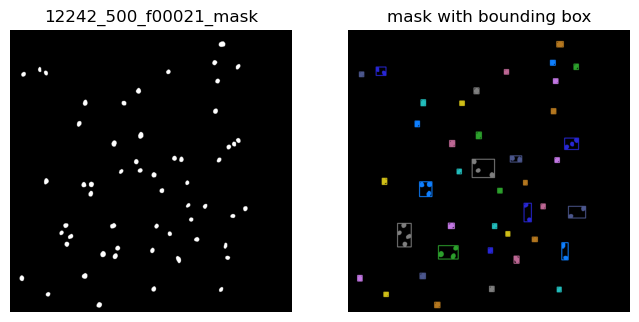

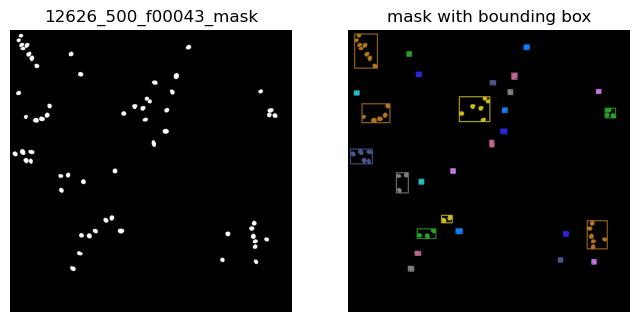

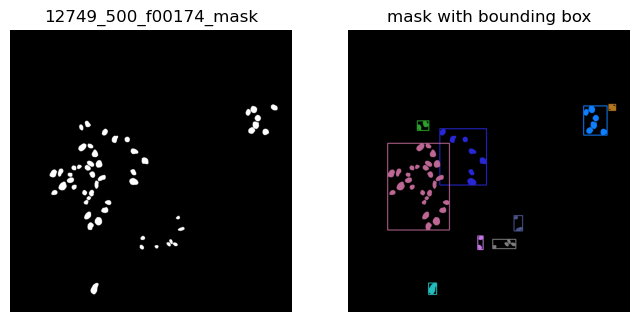

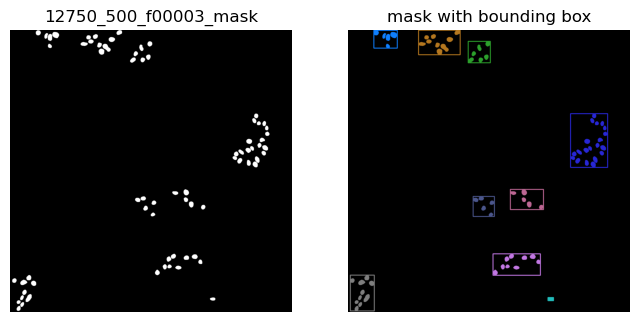

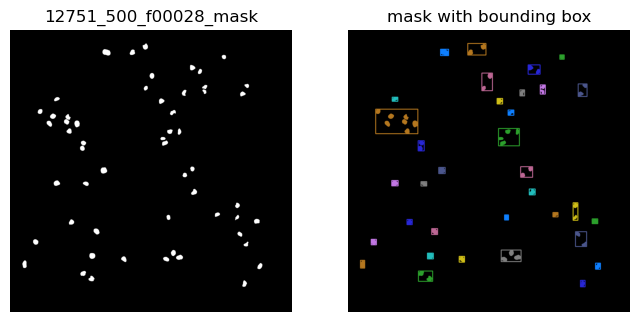

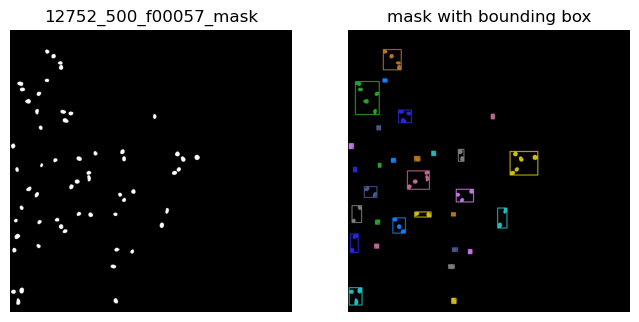

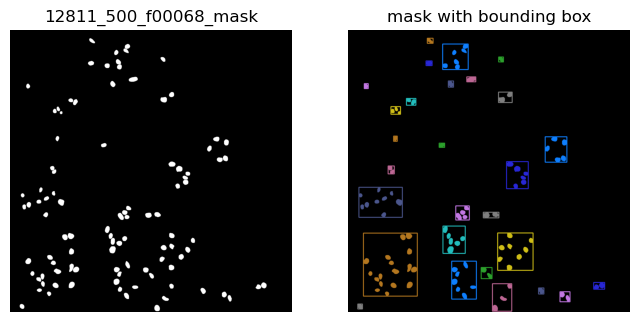

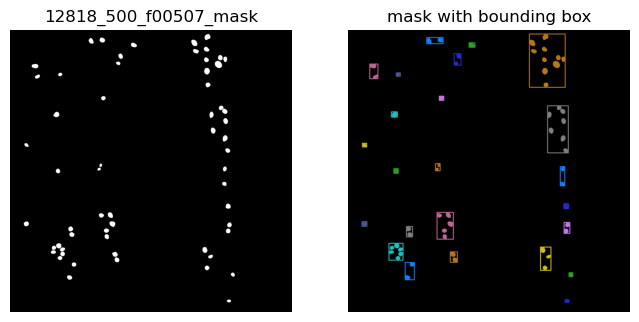

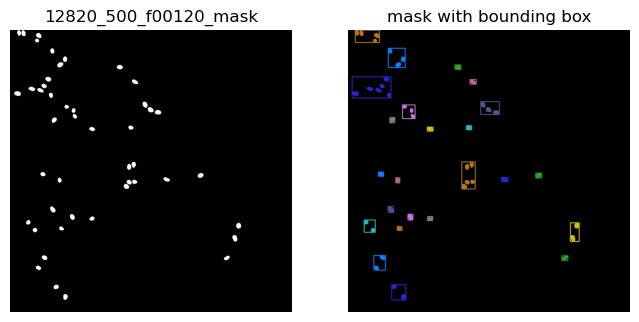

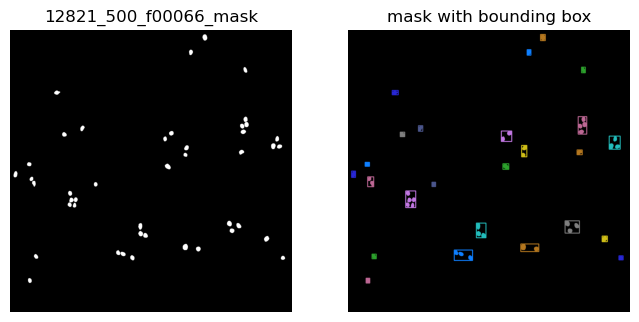

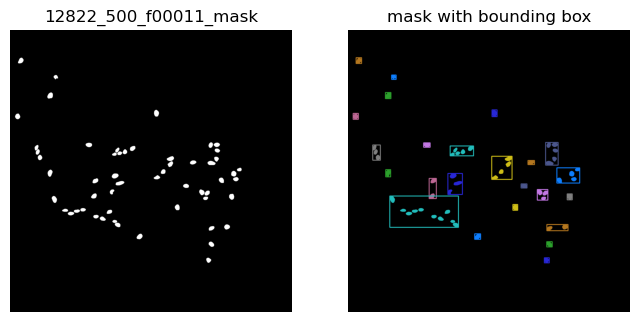

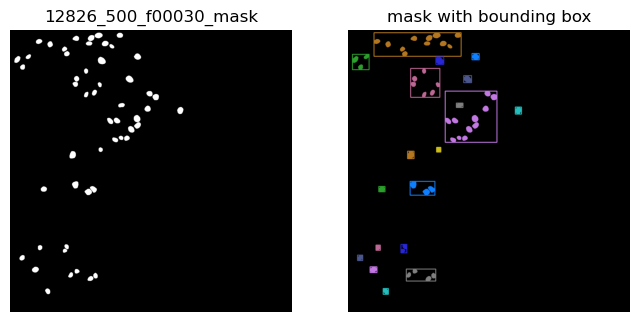

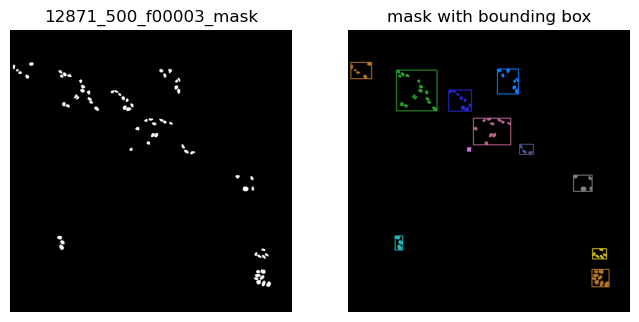

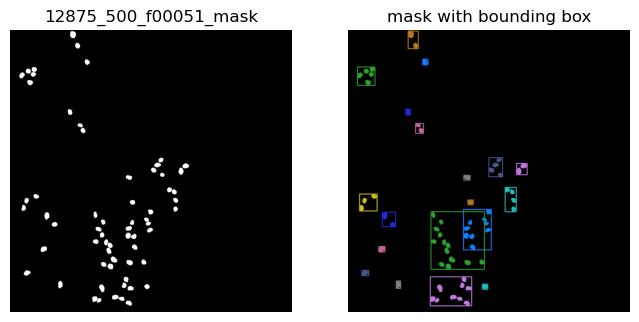

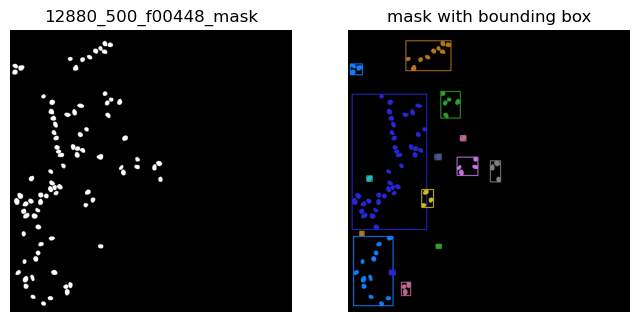

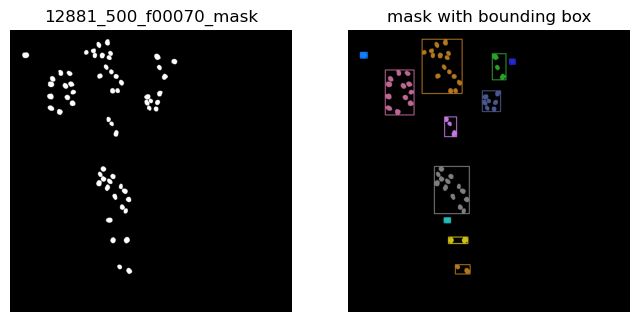

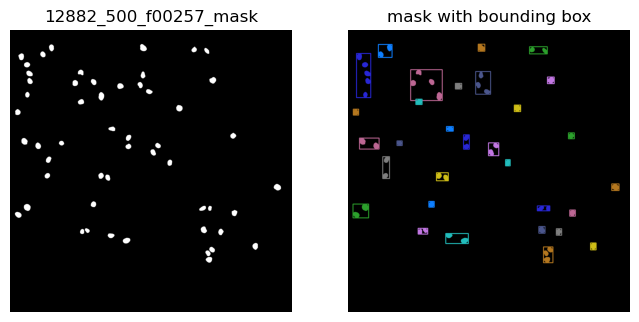

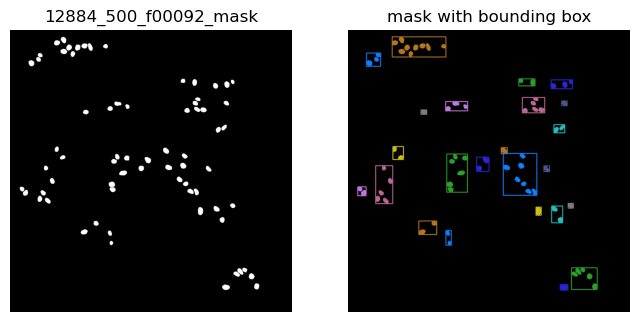

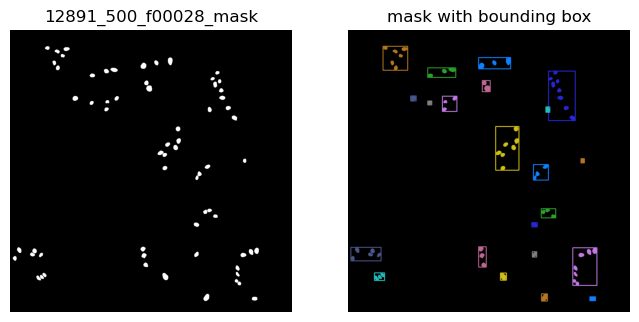

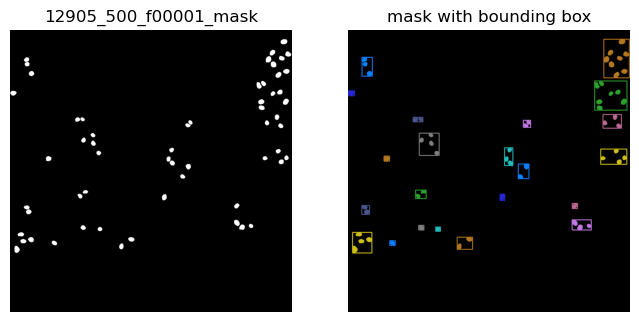

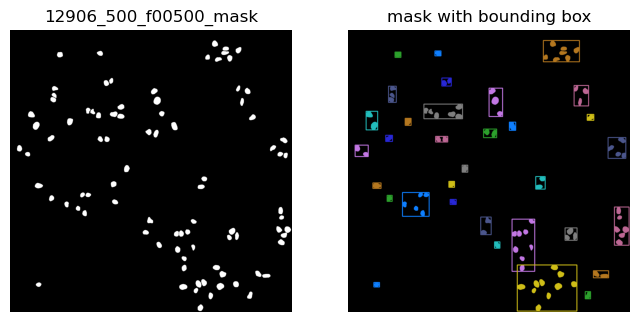

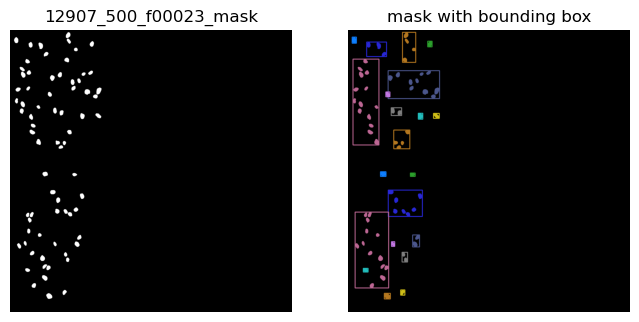

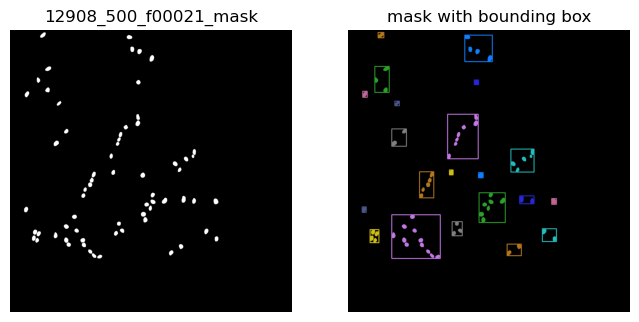

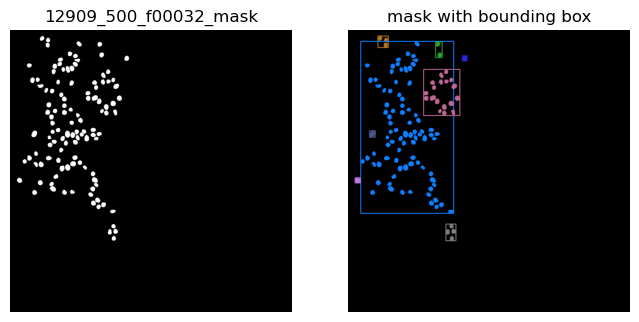

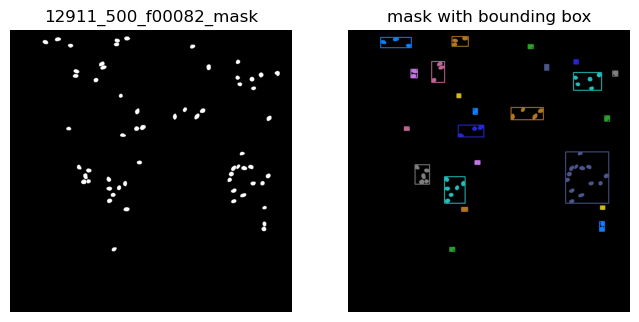

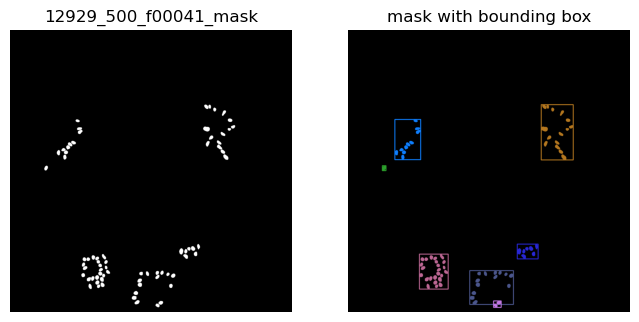

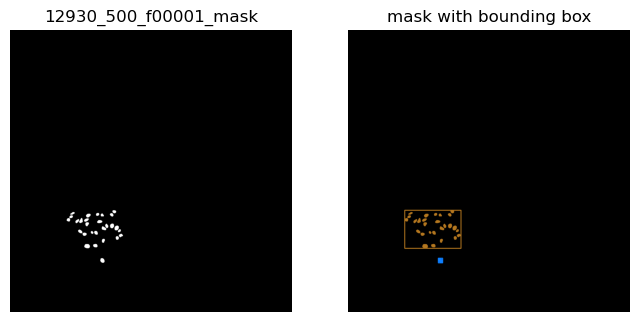

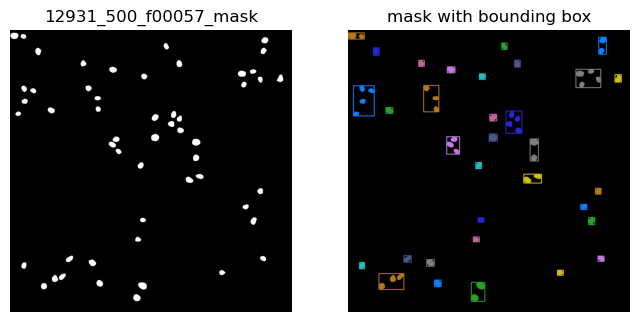

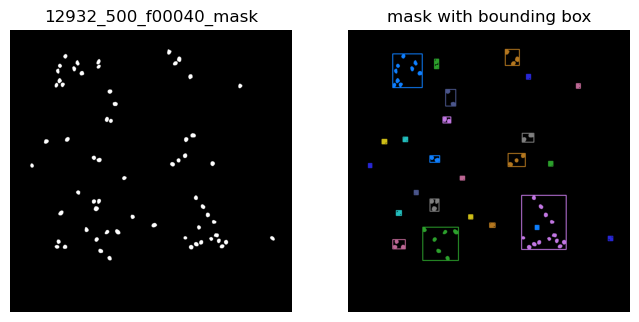

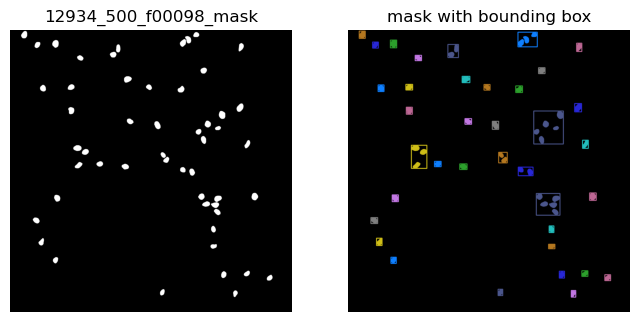

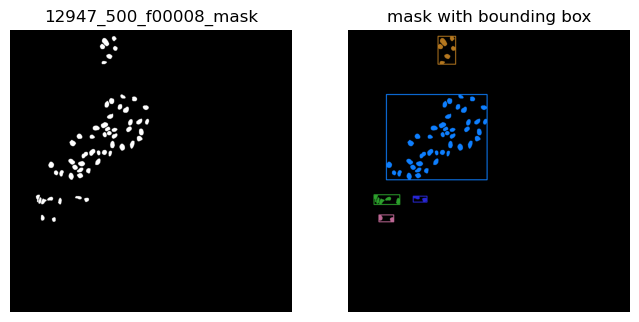

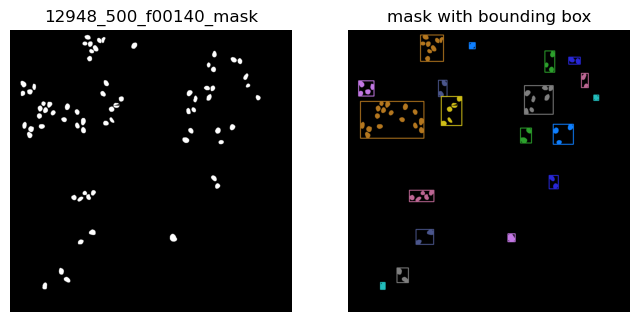

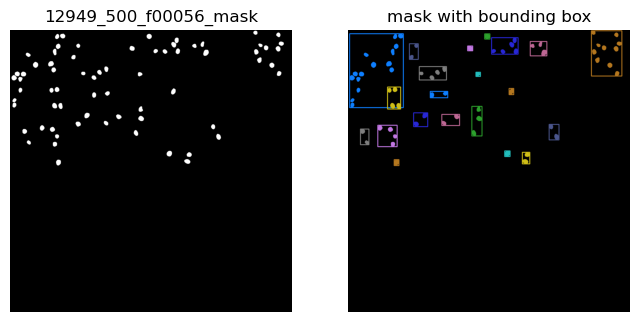

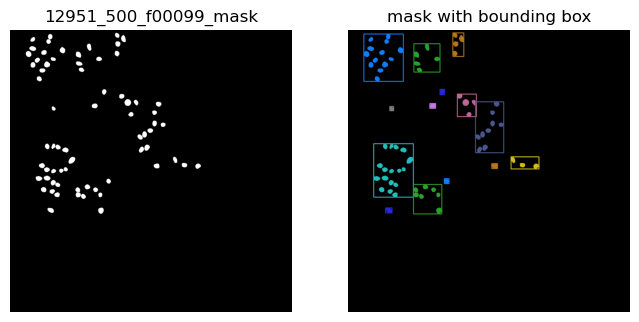

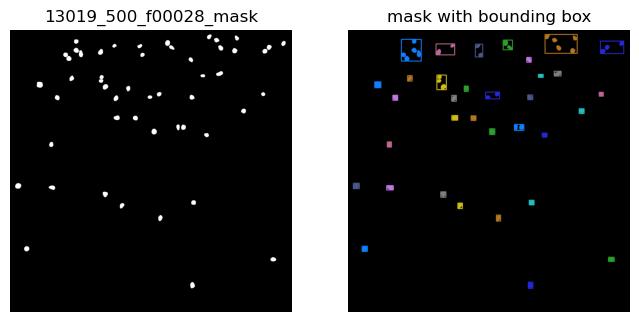

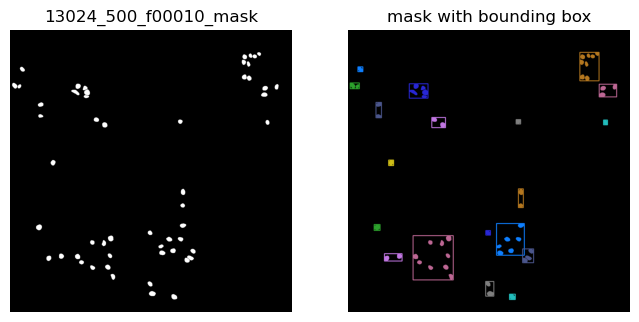

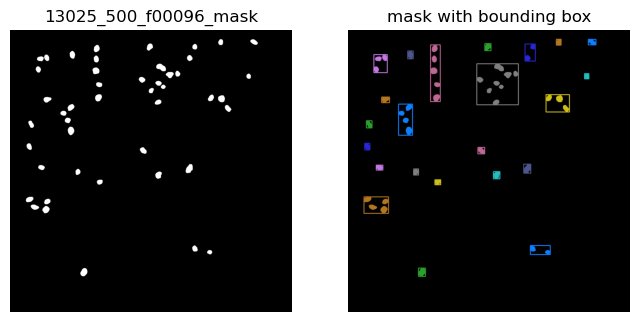

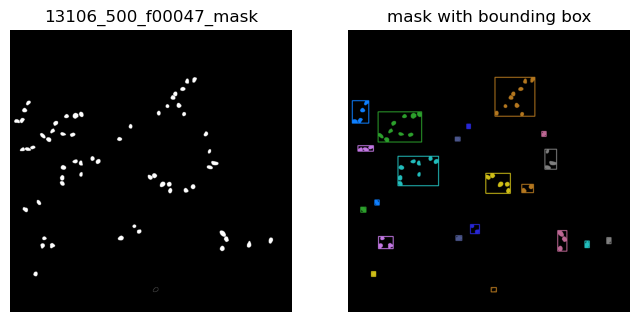

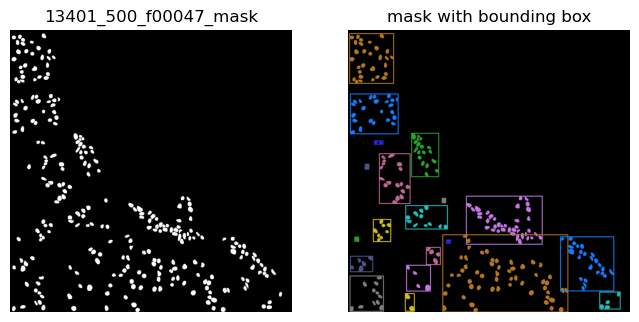

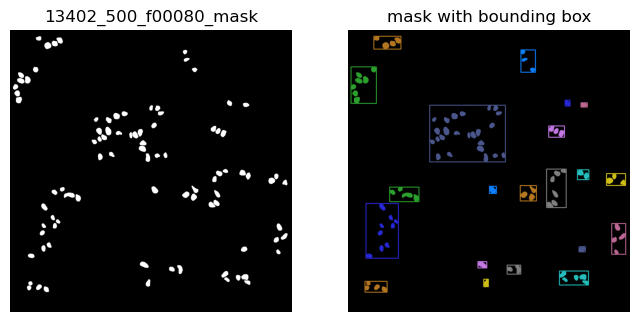

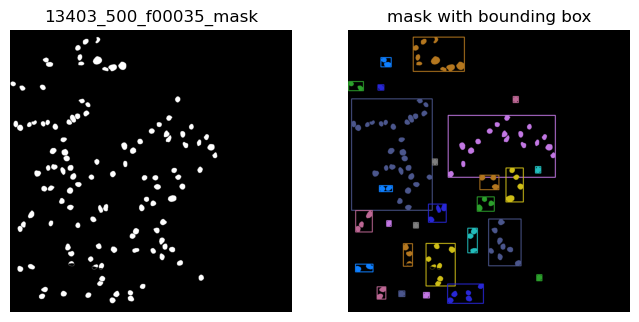

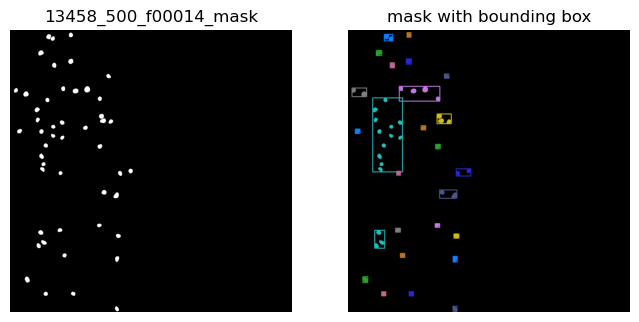

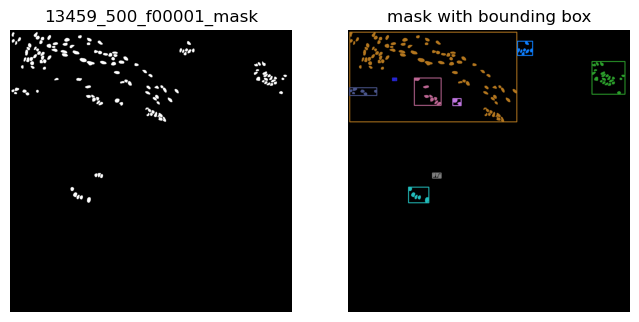

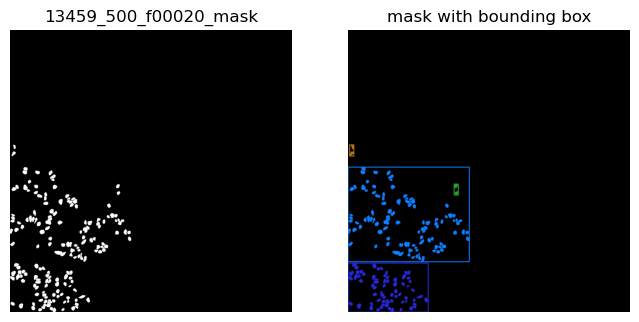

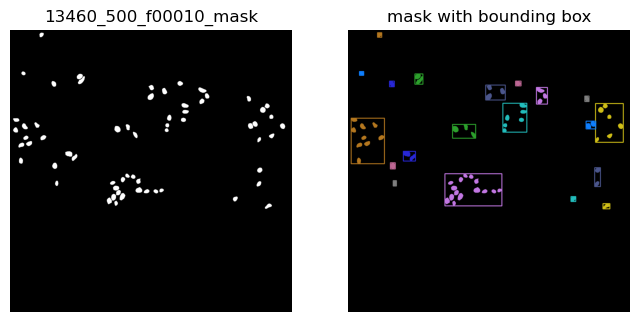

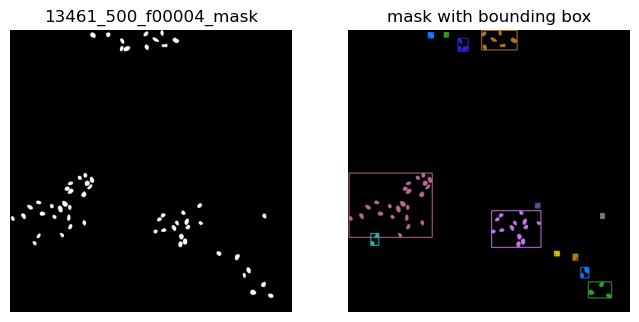

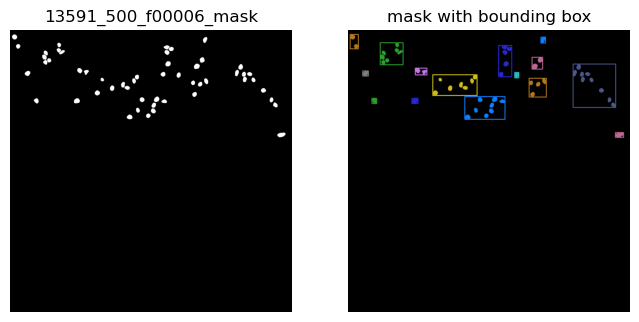

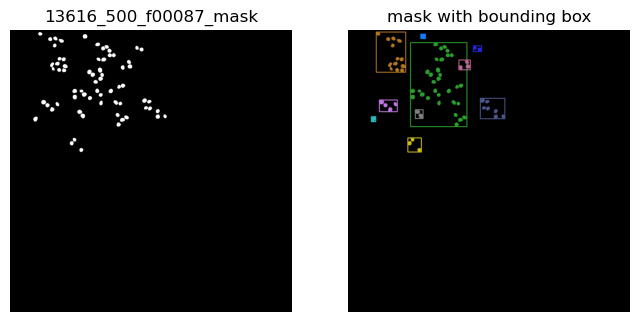

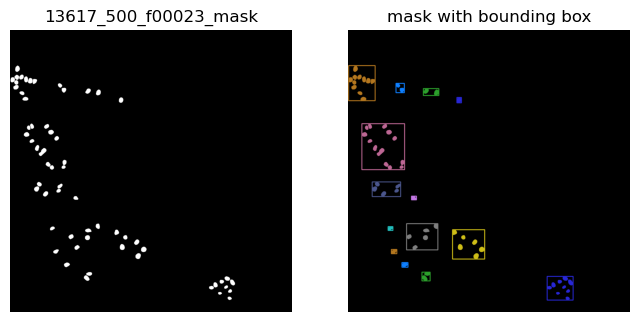

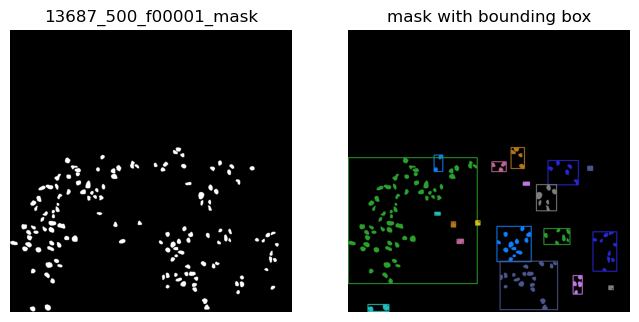

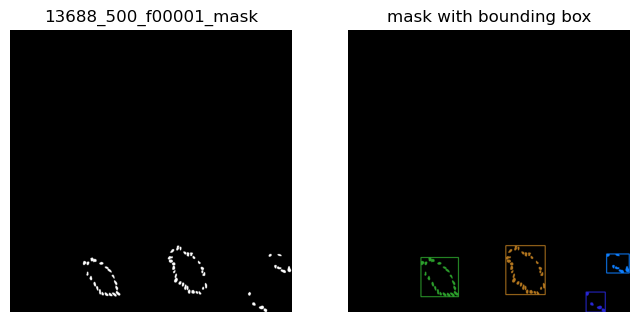

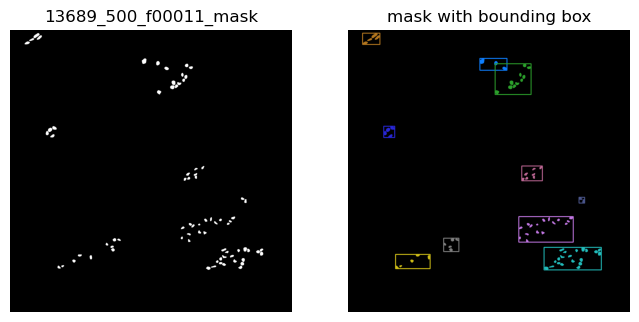

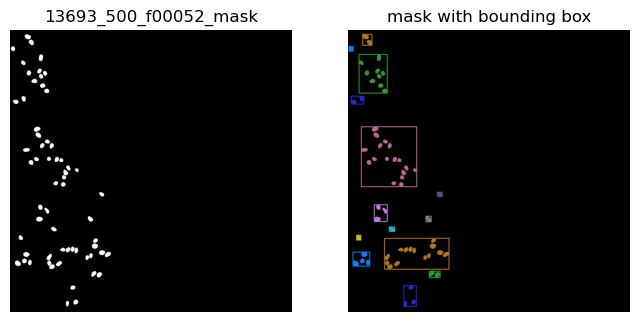

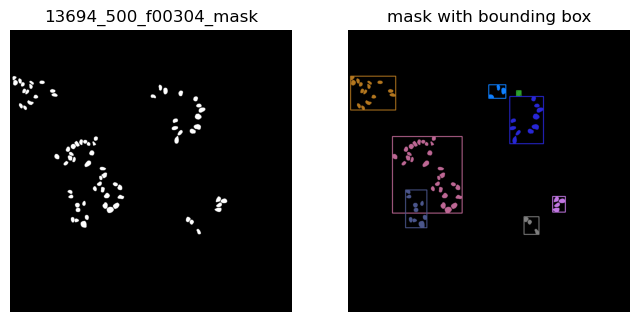

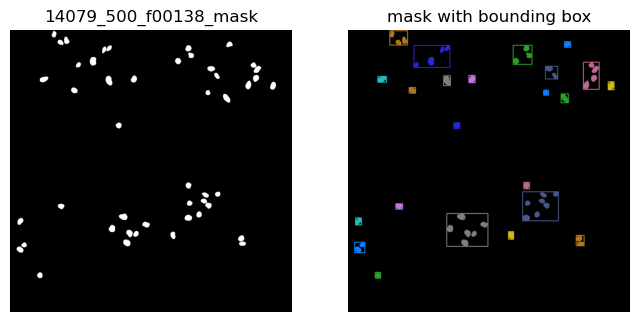

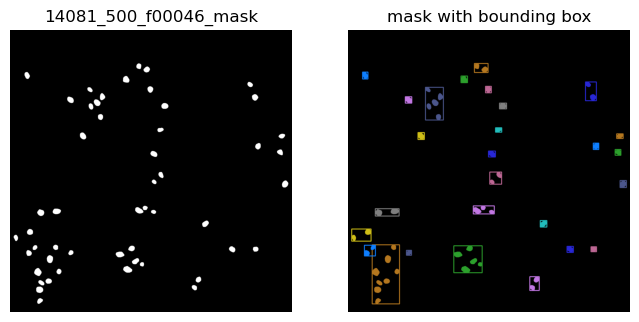

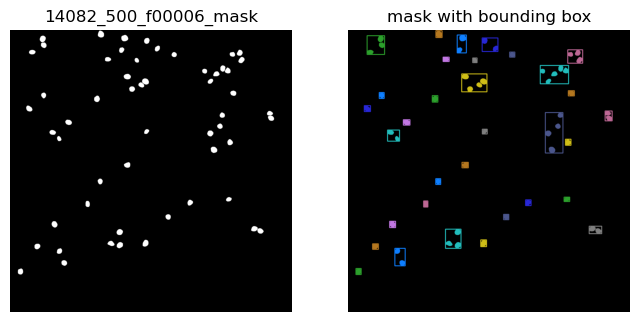

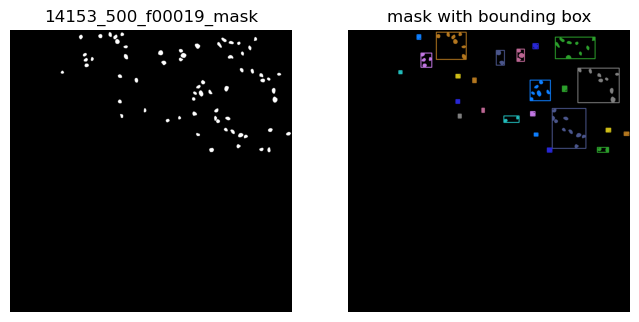

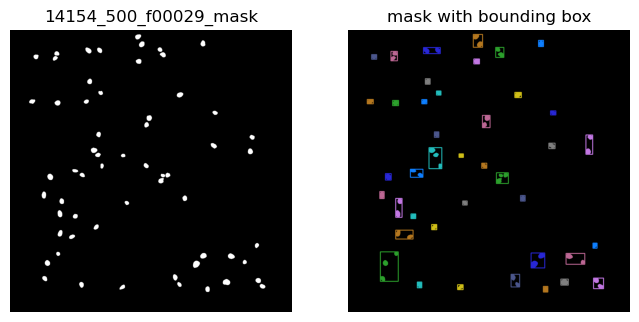

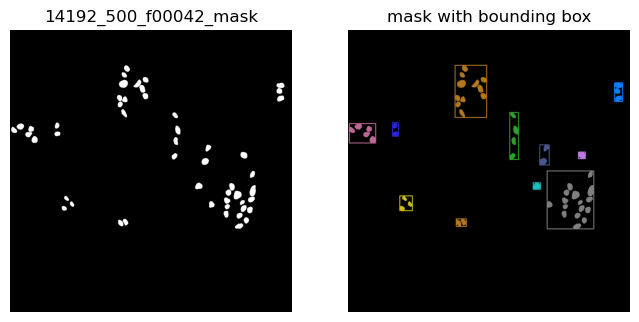

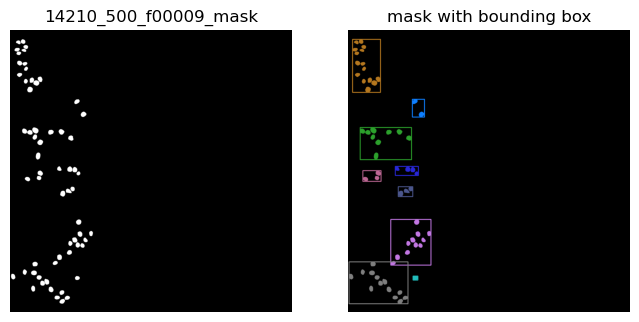

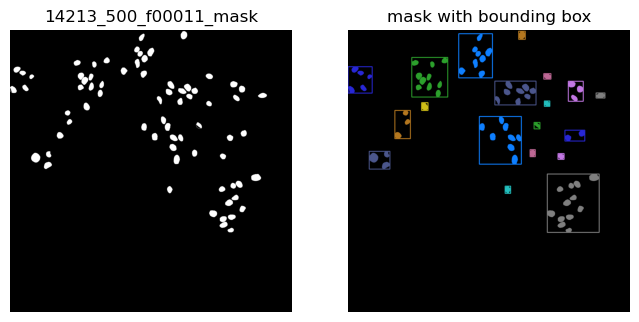

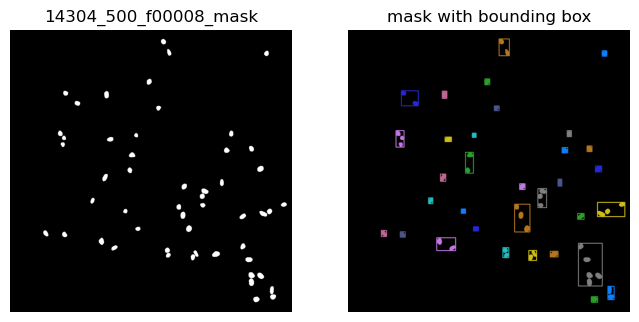

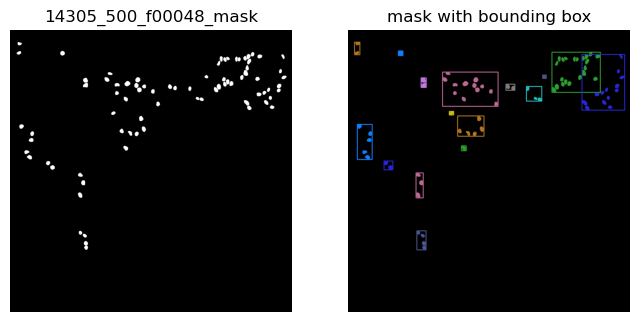

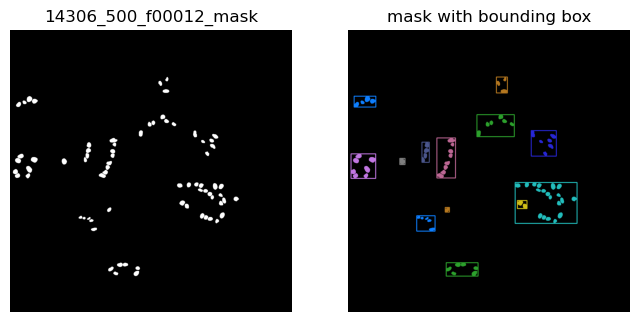

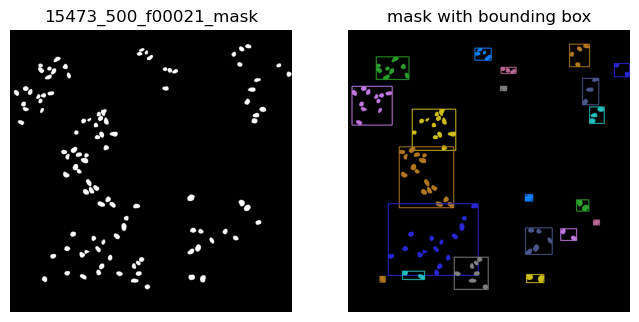

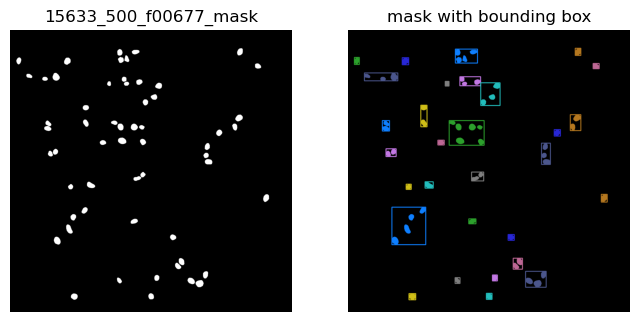

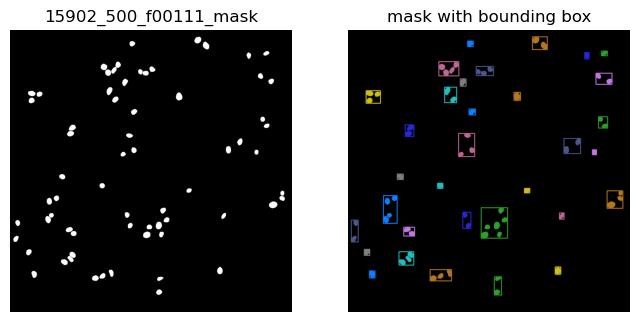

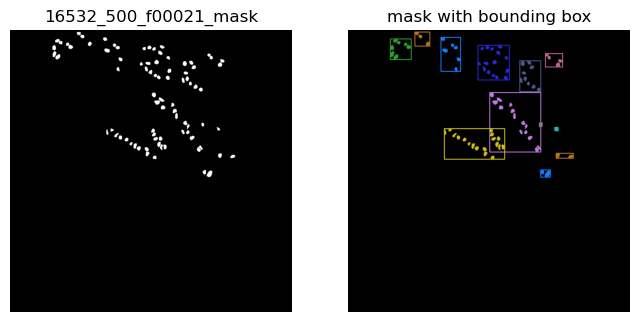

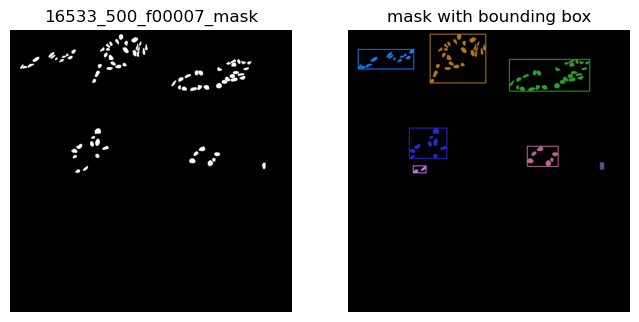

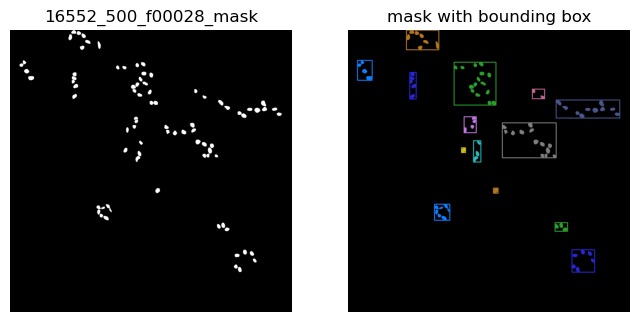

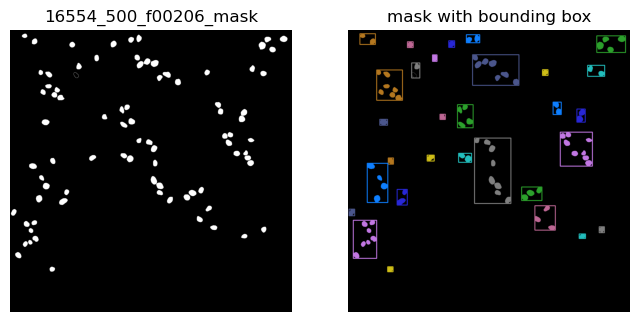

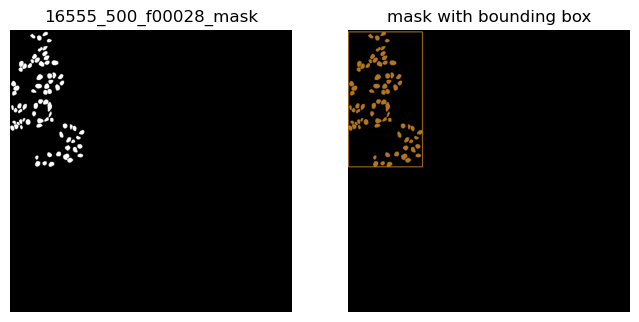

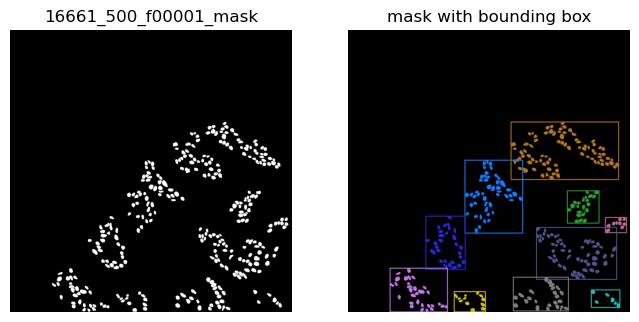

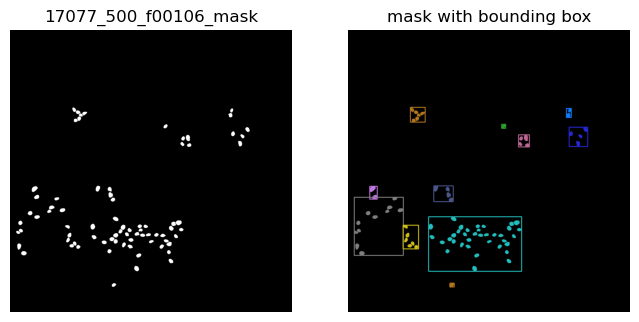

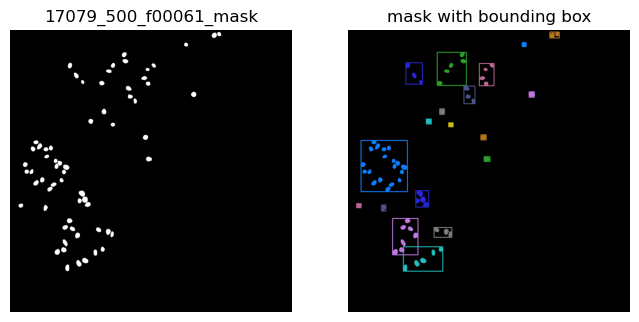

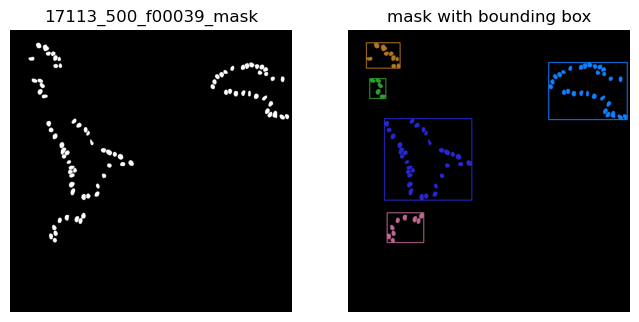

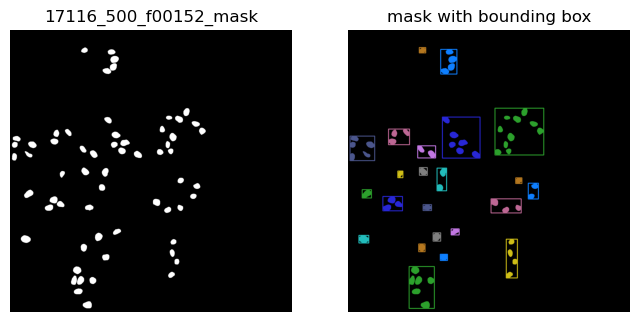

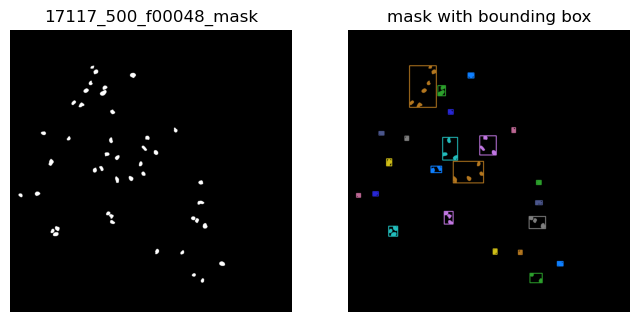

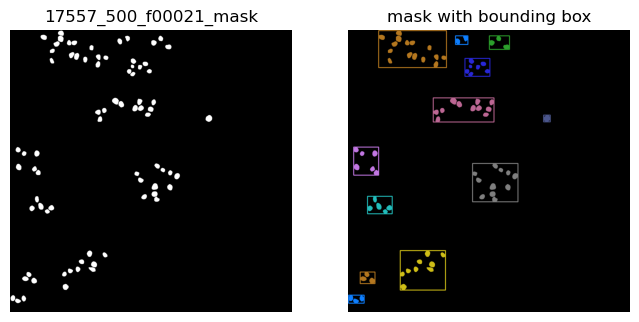

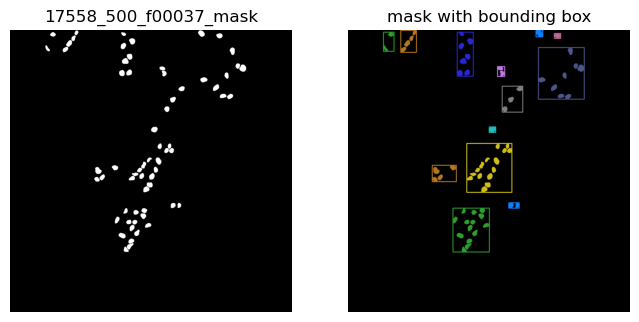

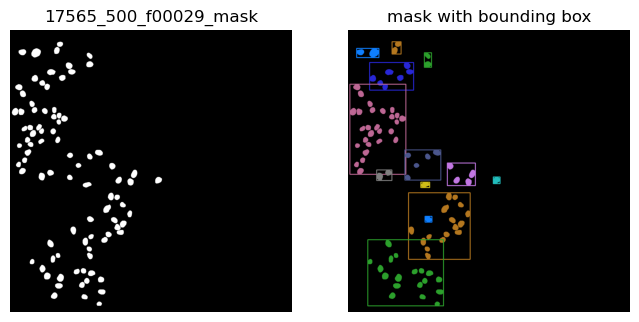

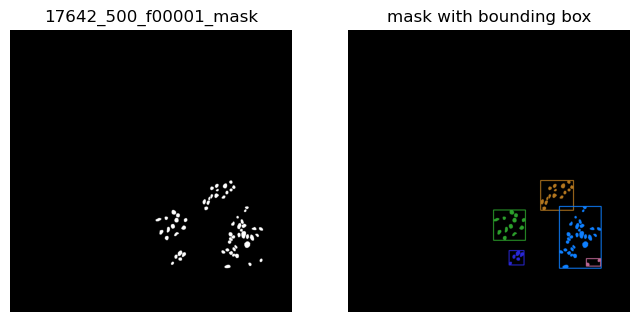

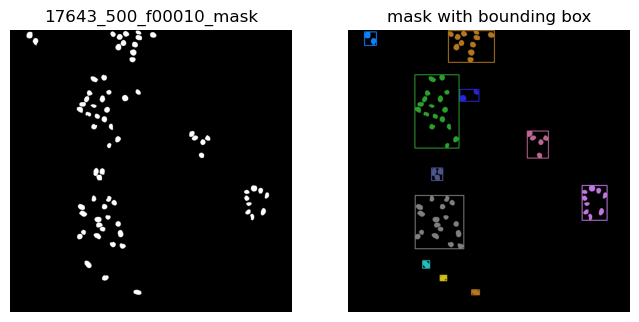

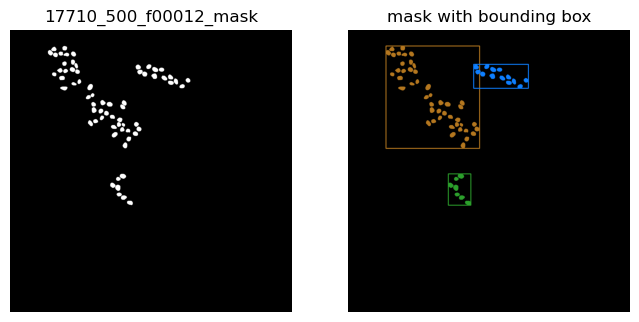

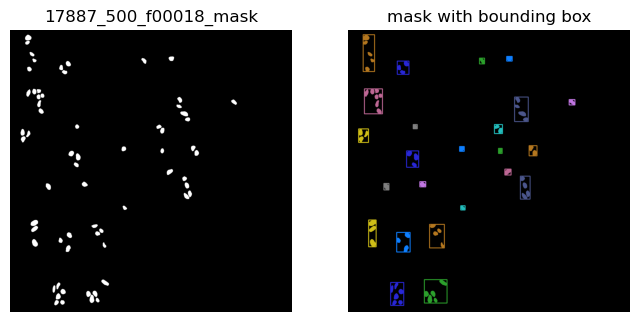

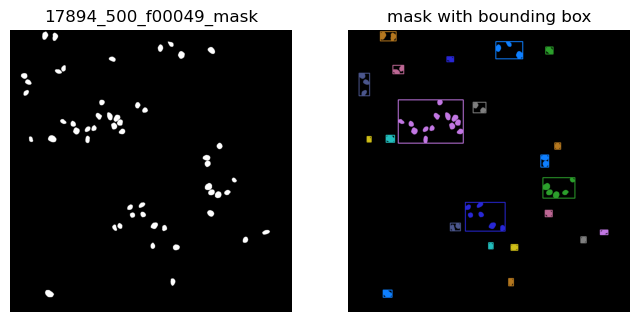

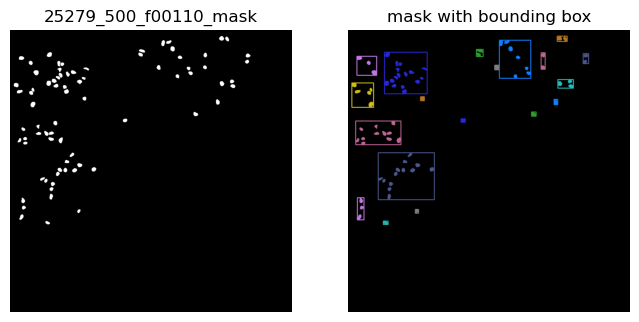

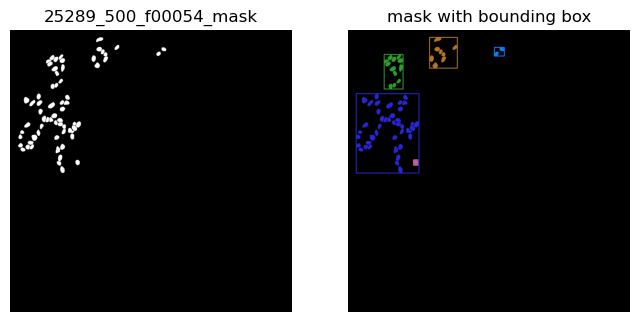

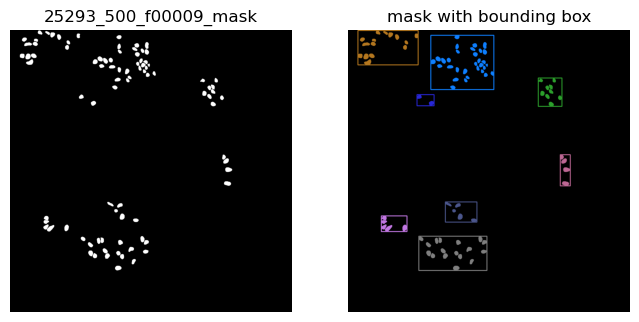

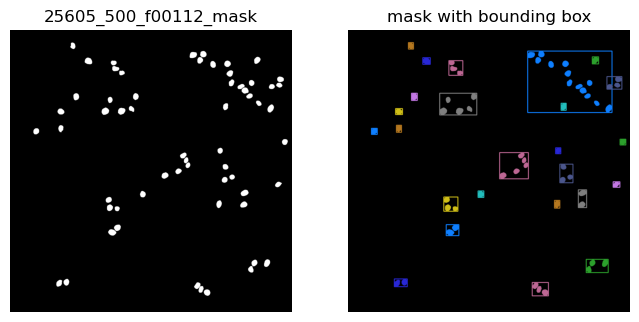

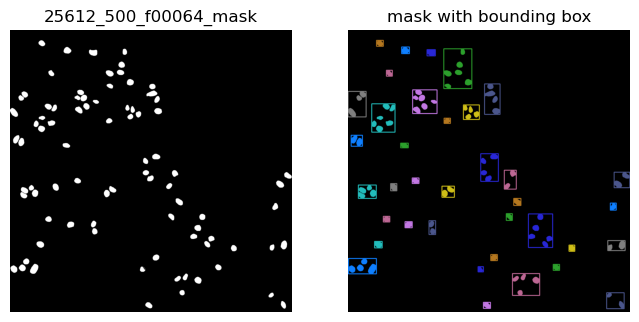

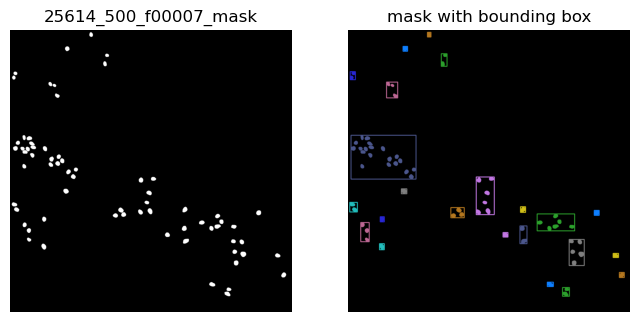

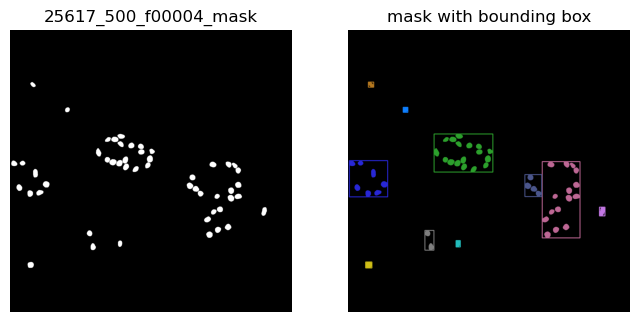

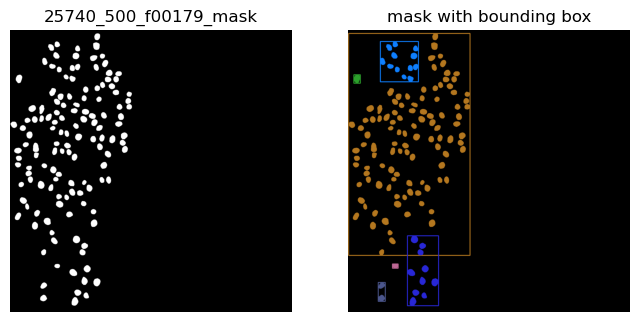

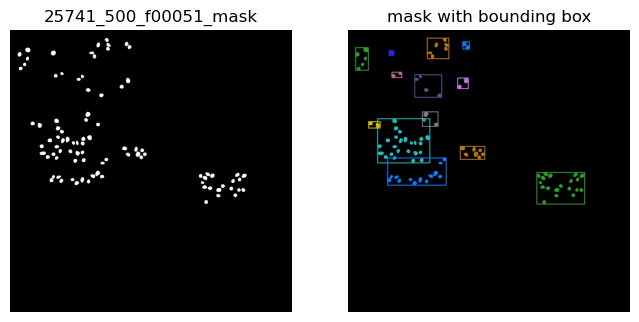

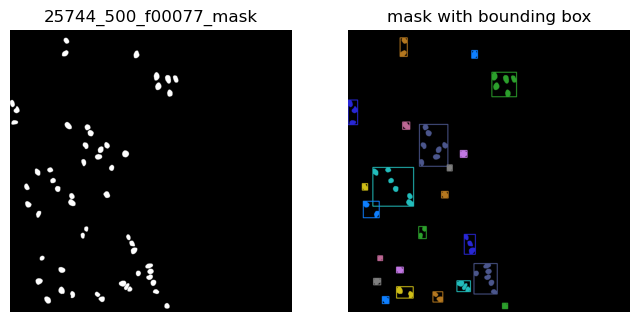

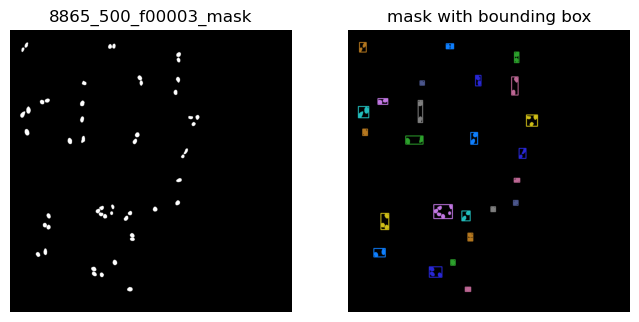

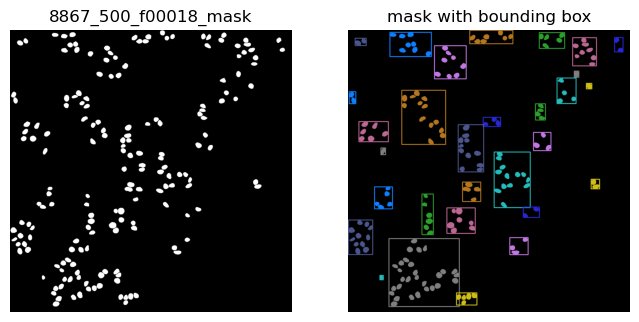

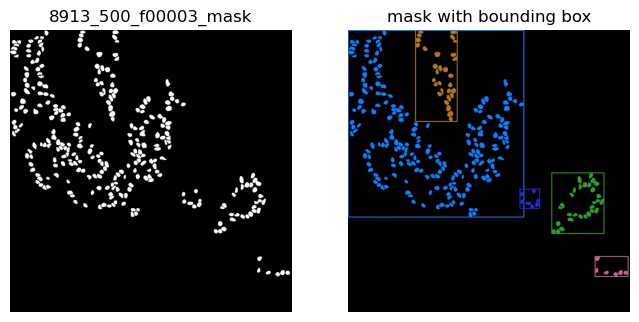

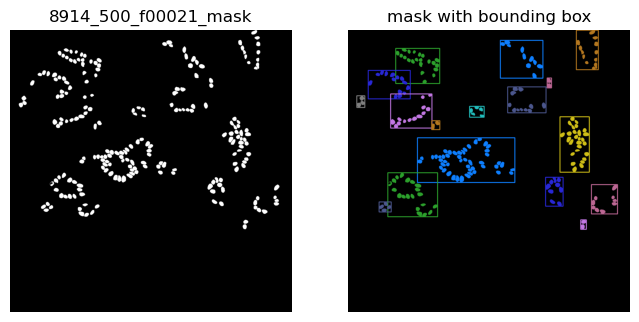

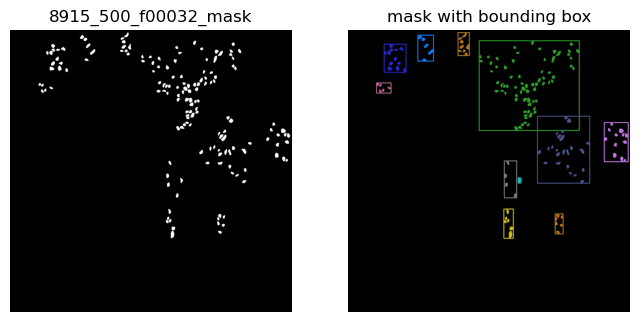

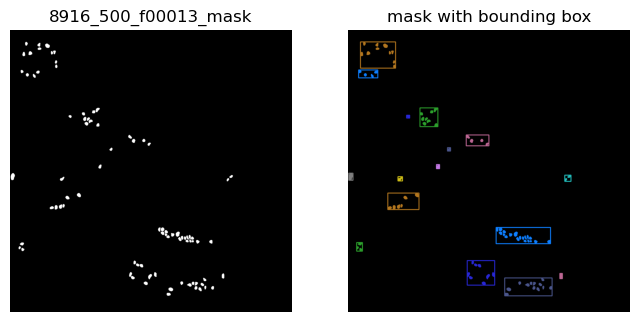

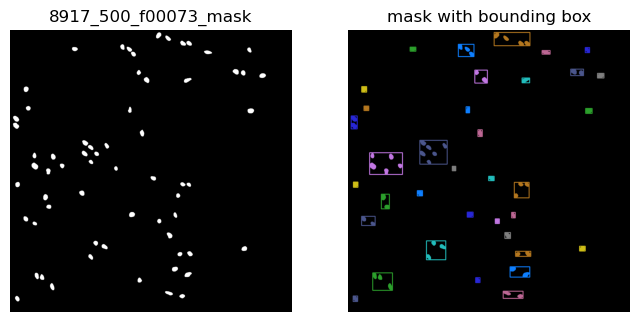

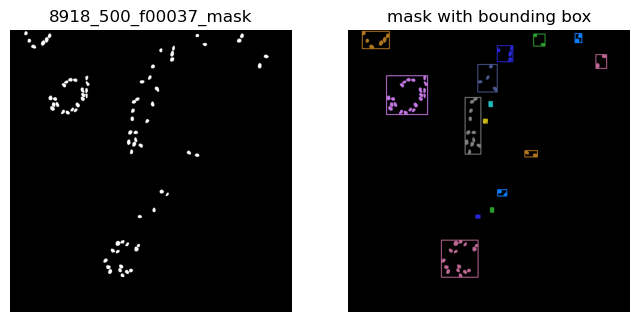

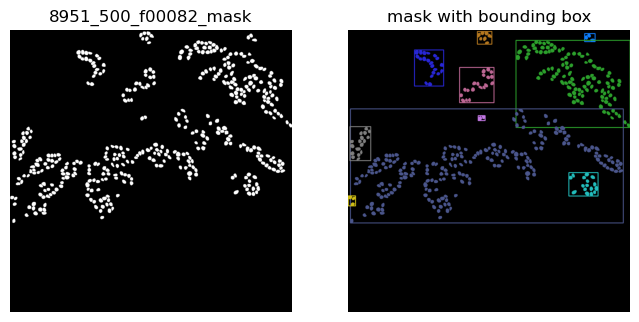

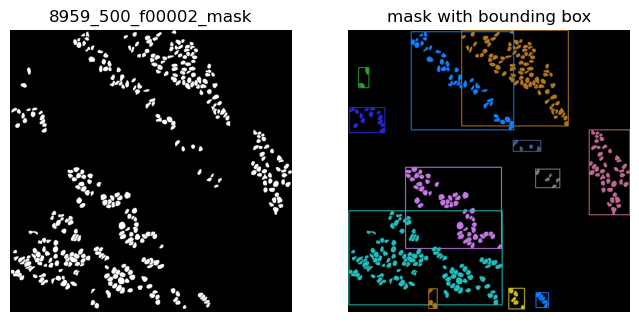

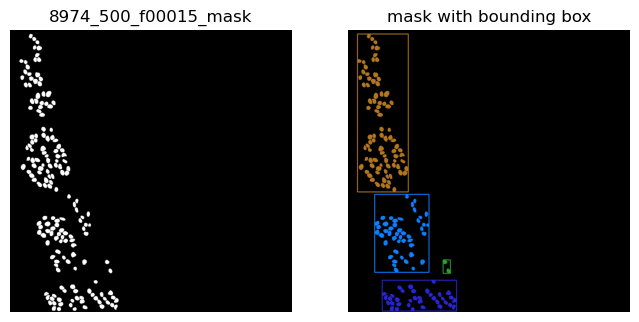

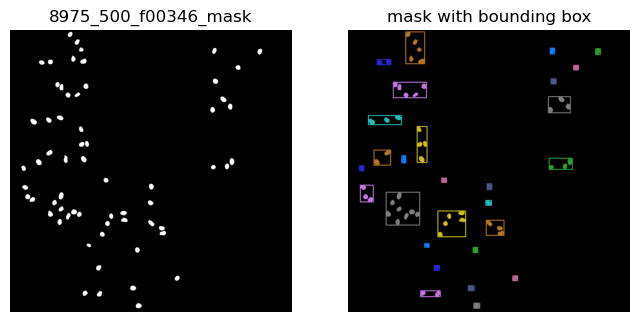

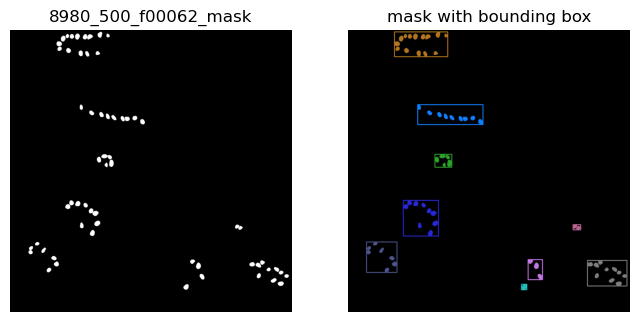

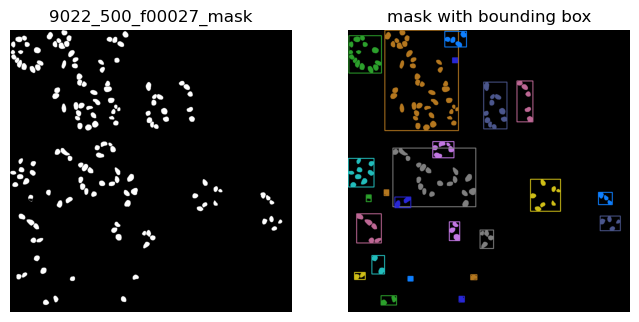

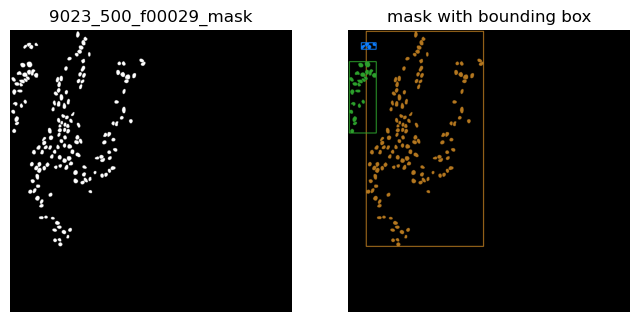

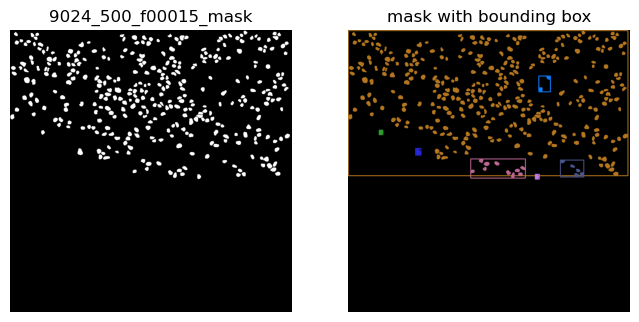

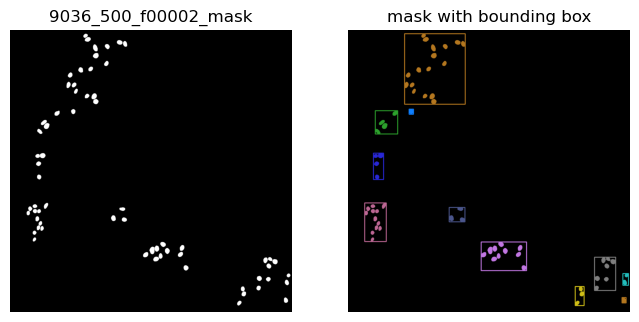

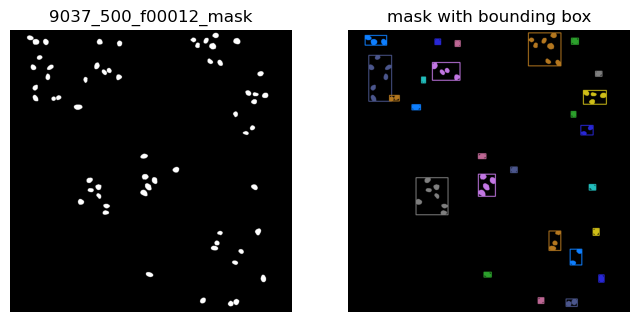

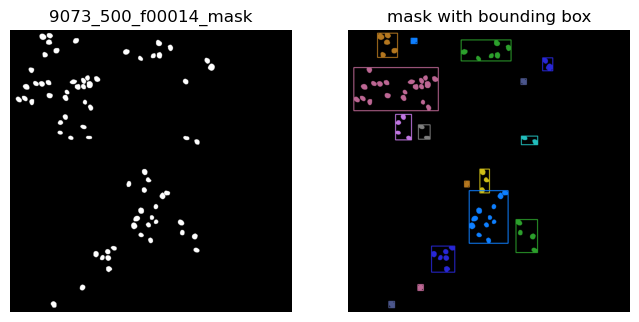

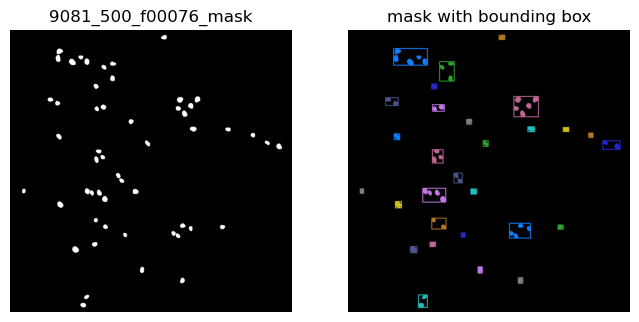

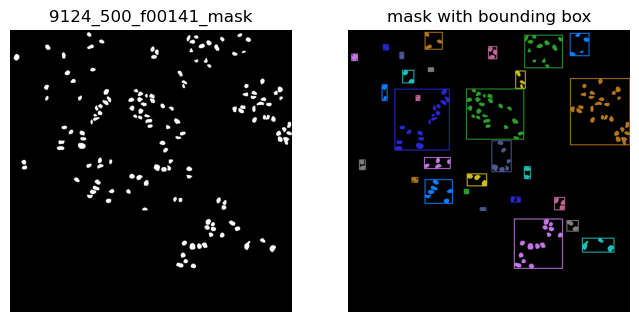

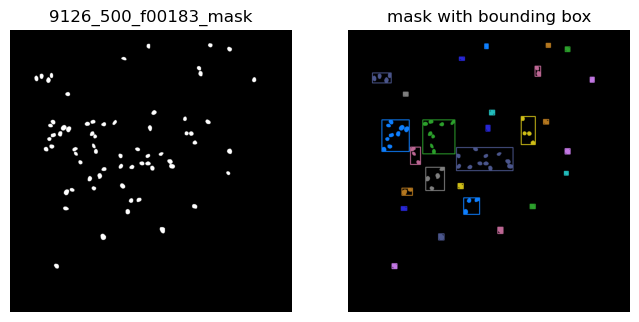

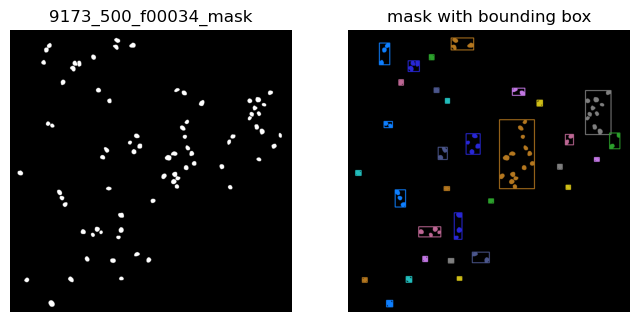

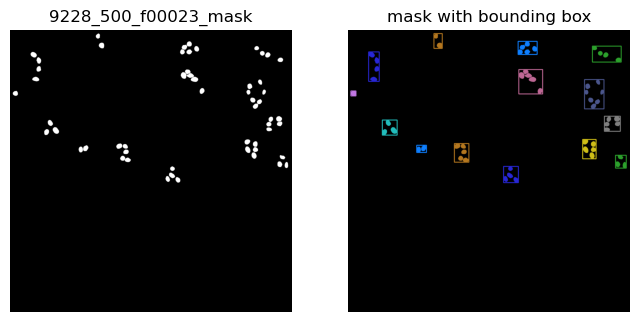

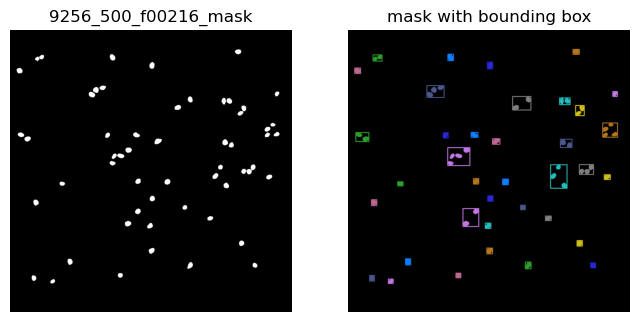

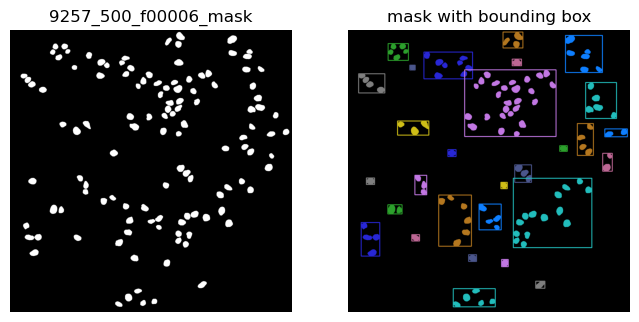

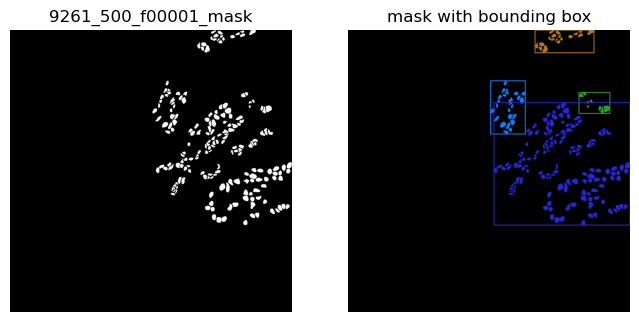

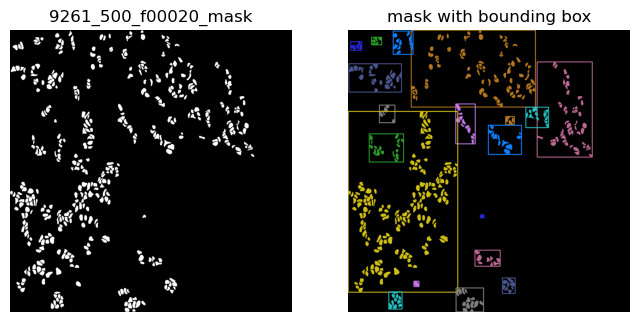

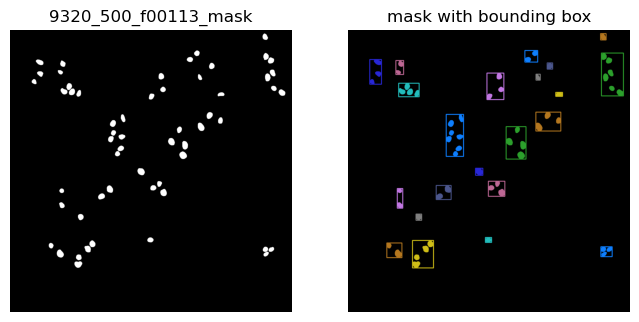

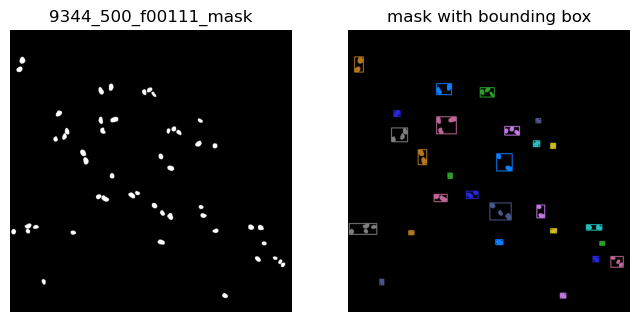

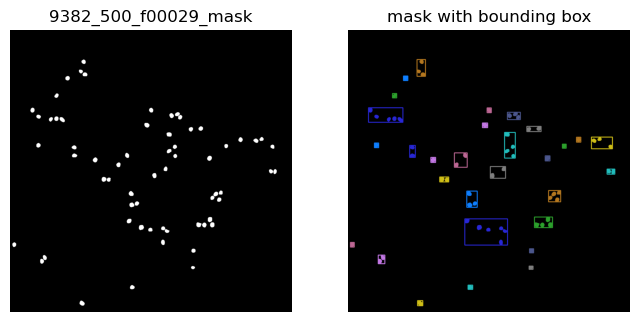

In [4]:
# Perform clustering on the masks to generate patches
count = 0
max_images = mask_count  # Change this to the number of images you want to process

# Predefined distinct colors for visualization
distinct_colors = [
    [31, 119, 180],  # Blue
    [255, 127, 14],  # Orange
    [44, 160, 44],   # Green
    [214, 39, 40],   # Red
    [148, 103, 189], # Purple
    [140, 86, 75],   # Brown
    [227, 119, 194], # Pink
    [127, 127, 127], # Gray
    [188, 189, 34],  # Yellow
    [23, 190, 207]   # Cyan
]

# Loop over all files in the directory
for filename in os.listdir(dataset_dir):
    bb_x_new = []
    bb_y_new = []
    bb_x_shift_new = []
    bb_y_shift_new = []
    if filename.endswith('_mask.png') and count < max_images:  # Check if the file is a PNG image
        # Read the image
        image_path = os.path.join(dataset_dir, filename)
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Convert the grayscale image to binary format
        _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

        # Find non-zero points (white points in binary image)
        points = np.column_stack(np.where(binary_image > 0))

        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=75, min_samples=6)
        clustering.fit(points)

        # Get the labels assigned to each point
        labels = clustering.labels_

        # Assign a unique color to each cluster label
        cluster_colors = {}
        for label in set(labels):
            if label == -1:
                # Noise points
                cluster_colors[label] = [0, 0, 0]
            else:
                cluster_colors[label] = distinct_colors[label % len(distinct_colors)]

        # Create blank images for visualization
        clustered_image = np.zeros_like(image)

        # Draw clusters on blank image and add bounding boxes
        for label, color in cluster_colors.items():
            if label == -1:
                continue
            cluster_points = points[labels == label]
            # Find bounding box coordinates
            x, y, w, h = cv2.boundingRect(cluster_points)

            # Rotate the bounding box by 90 degrees left
            new_x, new_y = y, image.shape[1] - x - w
            new_w, new_h = h, w

            # Flip vertically
            new_y, new_h = image.shape[0] - new_y - new_h, new_h

            cv2.rectangle(clustered_image, (new_x, new_y), (new_x + new_w, new_y + new_h), color, 5)  # Draw bounding box
            
            label_name = 'Cluster No.:' + str(label)
            
            # Add cluster number as label
            #cv2.putText(clustered_image, label_name, (new_x, new_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5, cv2.LINE_AA)

            bb_x_new.append(new_x)
            bb_y_new.append(new_y)
            bb_x_shift_new.append(new_x + new_w)
            bb_y_shift_new.append(new_y + new_h)
            
            for point in cluster_points:
                clustered_image[point[0], point[1]] = color
                
            # Save bounding box coordinates
            filename_without_png = filename.replace(".png", "")  # Remove the .png extension
            bbox_filename = os.path.join(bounding_box_dir, f"bounding_boxes_{filename_without_png}.txt")
            with open(bbox_filename, 'w') as file:
                for i, (x, y, x_shift, y_shift) in enumerate(zip(bb_x_new, bb_y_new, bb_x_shift_new, bb_y_shift_new)):
                    # Calculate width and height from the shift values
                    width = x_shift - x
                    height = y_shift - y
                    file.write(f"Cluster {i}: {x}, {y}, {width}, {height}\n")    
                
        # Plot original and clustered images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(filename_without_png)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(clustered_image, cv2.COLOR_BGR2RGB))
        plt.title('mask with bounding box')
        plt.axis('off')

        plt.show()

        count += 1
        if count == max_images:
            break

In [5]:
# Pre-processing images and masks
for bbox_file in os.listdir(bounding_box_dir):
    if bbox_file.endswith('.txt'):
        # Remove "bounding_boxes_" prefix and "_mask.png.txt" suffix to extract the common identifier
        common_identifier = bbox_file.replace("bounding_boxes_", "").replace("_mask.txt", "")

        # Construct the expected filenames for both original image and mask
        original_image_name = f"{common_identifier}_original.tif"
        mask_name = f"{common_identifier}_mask.png"
        original_image_path = os.path.join(dataset_dir, original_image_name)
        mask_path = os.path.join(dataset_dir, mask_name)

        # Check if both original image and mask exist
        if os.path.exists(original_image_path) and os.path.exists(mask_path):
            # Read the original image and mask
            original_image = cv2.imread(original_image_path)
            mask = cv2.imread(mask_path)

            # Open the bounding box file and read coordinates
            with open(os.path.join(bounding_box_dir, bbox_file), 'r') as f:
                for line in f:
                    parts = line.strip().split(': ')[1].split(', ')
                    x, y, w, h = map(int, parts)

                    # Generate sub-images based on bounding box coordinates
                    original_sub_image = original_image[y:y+h, x:x+w]
                    mask_sub_image = mask[y:y+h, x:x+w]

                    # Resize both sub-images to 64 x 64 pixels
                    resized_original_sub_image = cv2.resize(original_sub_image, (64, 64))
                    resized_mask_sub_image = cv2.resize(mask_sub_image, (64, 64))

                    # Save the resized sub-images
                    cluster_index = line.split(':')[0].split(' ')[1]
                    original_sub_image_filename = f"{common_identifier}_original_{cluster_index}.png"
                    mask_sub_image_filename = f"{common_identifier}_mask_{cluster_index}.png"
                    original_sub_image_path = os.path.join(data_dir, original_sub_image_filename)
                    mask_sub_image_path = os.path.join(data_dir, mask_sub_image_filename)
                    cv2.imwrite(original_sub_image_path, resized_original_sub_image)
                    cv2.imwrite(mask_sub_image_path, resized_mask_sub_image)

## Storing the Data

In [7]:
# Initialize lists for storing images, masks, and labels
images = []
masks = []
labels = []

# First, we count the total number of original images for the progress bar
total_image_files = sum(1 for filename in os.listdir(data_dir) if "_original_" in filename)
total_mask_files = sum(1 for filename in os.listdir(data_dir) if "_mask_" in filename)
total_files = total_image_files + total_mask_files
print(f"Total images found: {total_files}")

# Loop through the directory with a progress bar
for filename in tqdm(os.listdir(data_dir), total=total_files, desc="Processing images"):
    if "_original_" in filename:
        # Construct the filename for the corresponding mask
        mask_filename = filename.replace("_original_", "_mask_")
        
        # Extract patient ID (first 5 characters)
        # patient_id = filename[:5]  # Assuming the first 5 characters are the patient ID
        patient_id = filename.split('_', 1)[0] # Extracts the portion of the filename before the first underscore

        # Build the full path for the image and mask
        image_path = os.path.join(data_dir, filename)
        mask_path = os.path.join(data_dir, mask_filename)
        
        # Check if the corresponding mask file exists
        if os.path.exists(mask_path):
            # Read the image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale
            
            # Append the image, mask, and label (patient ID) to their respective lists
            images.append(image)
            masks.append(mask)
            labels.append(int(patient_id))  # Convert patient ID to int for consistency

# After processing all files, print the counts
print(f"Total processed image files: {len(images)}")
print(f"Total processed mask files: {len(masks)}")
print(f"Total labels collected: {len(labels)}")

# Convert lists to numpy arrays
images_array = np.array(images)
masks_array = np.array(masks)
labels_array = np.array(labels)

# Save arrays as .npy files
np.save("images.npy", images_array)
np.save("masks.npy", masks_array)
np.save("labels.npy", labels_array)

Total images found: 5220


Processing images: 100%|██████████| 5220/5220 [00:06<00:00, 820.55it/s] 

Total processed image files: 2610
Total processed mask files: 2610
Total labels collected: 2610


## Verifying the Data

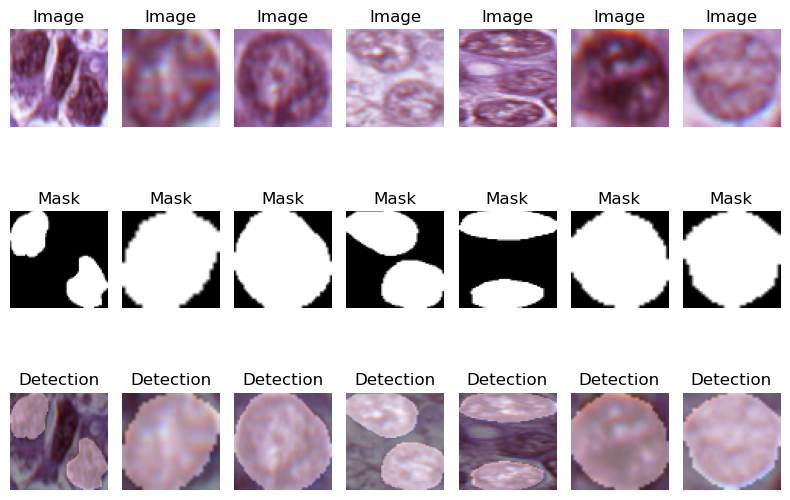

In [9]:
num_images = 7
fig, axes = plt.subplots(3, num_images, figsize=(8, 6))

# Generate random indices
rand_indices = np.random.choice(images_array.shape[0], num_images, replace=False)

for n, i in enumerate(rand_indices):
    # Display original image
    ax = axes[0, n]
    ax.imshow(images_array[i])
    ax.set_title("Image")
    ax.axis('off')

    # Display mask
    ax = axes[1, n]
    ax.imshow(masks_array[i], cmap='gray')
    ax.set_title("Mask")
    ax.axis('off')

    # Display overlay
    ax = axes[2, n]
    ax.imshow(images_array[i], cmap='gray')
    ax.imshow(masks_array[i], cmap='gray', alpha=0.4)  # Overlay with transparency
    ax.set_title("Detection")
    ax.axis('off')

plt.tight_layout()
plt.show()